### Process the real (raw) Merian data
1. Scale the image to `ZP = 27.0` (same as HSC).
2. Subtract background. **TODO: Have to consider the effect of background subtraction and image scaling on the weight map.**
3. Extract PSF at a given position
    
    Download and install `psfex`: https://github.com/esheldon/psfex

    Documentation: https://psfex.readthedocs.io/en/latest/GettingStarted.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

In [3]:
import sep
from kuaizi.utils import save_to_fits
import os
import sys

In [4]:
# yifei_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/COSMOS_tractor_gaap.fits')

In [5]:
cutout_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/t9813_deep/hsc_merian_COSMOS_galaxy.fits')

In [6]:
temp = cutout_cat[(cutout_cat['z_cosmos'] > 0.02) & (cutout_cat['z_cosmos'] < 0.2)]
temp['half_size'] = 2 * temp['g_kronRad'] * u.arcsec

temp[:500].write(
    '/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/t9813_deep/COSMOS_lowz_hsc_merian.fits', overwrite=True)

# cutout_cat[(cutout_cat['z_cosmos'] > 0.2) & (cutout_cat['z_cosmos'] < 0.35)].write(
#     '/scratch/gpfs/jiaxuanl/Data/Merian/Catalogs/COSMOS_cutouts_tractor_gaap_midz_calexp.fits', overwrite=True)

In [7]:
temp

coord_ra,coord_dec,y_ra,y_decl,y_psfFlux,y_psfFluxErr,y_free_psfFlux,y_free_psfFluxErr,y_free_psfFlux_flag,y_gaapPsfFlux,y_gaapPsfFluxErr,y_gaap0p5Flux,y_gaap0p5FluxErr,y_gaap0p7Flux,y_gaap0p7FluxErr,y_gaap1p0Flux,y_gaap1p0FluxErr,y_gaap1p5Flux,y_gaap1p5FluxErr,y_gaap2p5Flux,y_gaap2p5FluxErr,y_gaap3p0Flux,y_gaap3p0FluxErr,y_gaapOptimalFlux,y_gaapOptimalFluxErr,y_kronRad,y_kronFlux,y_kronFluxErr,y_calibFlux,y_calibFluxErr,y_ap03Flux,y_ap03FluxErr,y_ap03Flux_flag,y_ap06Flux,y_ap06FluxErr,y_ap06Flux_flag,y_ap09Flux,y_ap09FluxErr,y_ap09Flux_flag,y_ap12Flux,y_ap12FluxErr,y_ap12Flux_flag,y_ap17Flux,y_ap17FluxErr,y_ap17Flux_flag,y_ap25Flux,y_ap25FluxErr,y_ap25Flux_flag,y_ap35Flux,y_ap35FluxErr,y_ap35Flux_flag,y_ap50Flux,y_ap50FluxErr,y_ap50Flux_flag,y_ap70Flux,y_ap70FluxErr,y_ap70Flux_flag,y_extendedness,y_blendedness,y_fwhm,y_cModelFlux,y_cModelFluxErr,y_cModelFlux_inner,y_free_cModelFlux,y_free_cModelFluxErr,y_free_cModelFlux_inner,y_free_cModelFlux_flag,y_hsmShapeRegauss_e1,y_hsmShapeRegauss_e2,y_hsmShapeRegauss_sigma,y_hsmShapeRegauss_flag,y_inputCount,y_inputCount_flag,y_inputCount_flag_noInputs,y_psfFlux_area,y_psfFlux_flag,y_psfFlux_flag_apCorr,y_psfFlux_flag_edge,y_psfFlux_flag_noGoodPixels,y_cModel_flag,y_cModel_flag_apCorr,y_gaapFlux_flag,y_gaapFlux_flag_edge,y_gaapFlux_flag_gaussianization,y_gaapOptimalFlux_flag_bigPsf,y_gaap0p5Flux_flag_bigPsf,y_gaap0p7Flux_flag_bigPsf,y_gaap1p0Flux_flag_bigPsf,y_gaap1p5Flux_flag_bigPsf,y_gaap2p5Flux_flag_bigPsf,y_gaap3p0Flux_flag_bigPsf,y_blendedness_flag,y_pixelFlags_bad,y_pixelFlags_clipped,y_pixelFlags_clippedCenter,y_pixelFlags_cr,y_pixelFlags_crCenter,y_pixelFlags_edge,y_pixelFlags_inexact_psf,y_pixelFlags_inexact_psfCenter,y_pixelFlags_interpolated,y_pixelFlags_interpolatedCenter,y_pixelFlags_offimage,y_pixelFlags_saturated,y_pixelFlags_saturatedCenter,y_pixelFlags_sensor_edge,y_pixelFlags_sensor_edgeCenter,y_pixelFlags_suspect,y_pixelFlags_suspectCenter,y_extendedness_flag,y_calib_astrometry_used,y_calib_photometry_reserved,y_calib_photometry_used,y_calib_psf_candidate,y_calib_psf_reserved,y_calib_psf_used,y_apFlux_flag,y_apFlux_flag_apertureTruncated,y_apFlux_flag_sincCoeffsTruncated,y_calibFlux_flag,y_calibFlux_flag_apertureTruncated,y_calibFlux_flag_sincCoeffsTruncated,y_centroid_flag,y_centroid_x,y_centroid_xErr,y_centroid_y,y_centroid_yErr,y_kronFlux_flag,y_kronFlux_flag_bad_radius,y_kronFlux_flag_bad_shape,y_kronFlux_flag_bad_shape_no_psf,y_kronFlux_flag_edge,y_kronFlux_flag_no_fallback_radius,y_kronFlux_flag_no_minimum_radius,y_kronFlux_flag_small_radius,y_kronFlux_flag_used_minimum_radius,y_kronFlux_flag_used_psf_radius,z_ra,z_decl,z_psfFlux,z_psfFluxErr,z_free_psfFlux,z_free_psfFluxErr,z_free_psfFlux_flag,z_gaapPsfFlux,z_gaapPsfFluxErr,z_gaap0p5Flux,z_gaap0p5FluxErr,z_gaap0p7Flux,z_gaap0p7FluxErr,z_gaap1p0Flux,z_gaap1p0FluxErr,z_gaap1p5Flux,z_gaap1p5FluxErr,z_gaap2p5Flux,z_gaap2p5FluxErr,z_gaap3p0Flux,z_gaap3p0FluxErr,z_gaapOptimalFlux,z_gaapOptimalFluxErr,z_kronRad,z_kronFlux,z_kronFluxErr,z_calibFlux,z_calibFluxErr,z_ap03Flux,z_ap03FluxErr,z_ap03Flux_flag,z_ap06Flux,z_ap06FluxErr,z_ap06Flux_flag,z_ap09Flux,z_ap09FluxErr,z_ap09Flux_flag,z_ap12Flux,z_ap12FluxErr,z_ap12Flux_flag,z_ap17Flux,z_ap17FluxErr,z_ap17Flux_flag,z_ap25Flux,z_ap25FluxErr,z_ap25Flux_flag,z_ap35Flux,z_ap35FluxErr,z_ap35Flux_flag,z_ap50Flux,z_ap50FluxErr,z_ap50Flux_flag,z_ap70Flux,z_ap70FluxErr,z_ap70Flux_flag,z_extendedness,z_blendedness,z_fwhm,z_cModelFlux,z_cModelFluxErr,z_cModelFlux_inner,z_free_cModelFlux,z_free_cModelFluxErr,z_free_cModelFlux_inner,z_free_cModelFlux_flag,z_hsmShapeRegauss_e1,z_hsmShapeRegauss_e2,z_hsmShapeRegauss_sigma,z_hsmShapeRegauss_flag,z_inputCount,z_inputCount_flag,z_inputCount_flag_noInputs,z_psfFlux_area,z_psfFlux_flag,z_psfFlux_flag_apCorr,z_psfFlux_flag_edge,z_psfFlux_flag_noGoodPixels,z_cModel_flag,z_cModel_flag_apCorr,z_gaapFlux_flag,z_gaapFlux_flag_edge,z_gaapFlux_flag_gaussianization,z_gaapOptimalFlux_flag_bigPsf,z_gaap0p5Flux_flag_bigPsf,z_gaap0p7Flux_flag_bigPsf,z

In [63]:
hdu = fits.open('/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/cosmos_gal/1/276680/cosmos_276680_g_deepCoadd_calexp.fits')

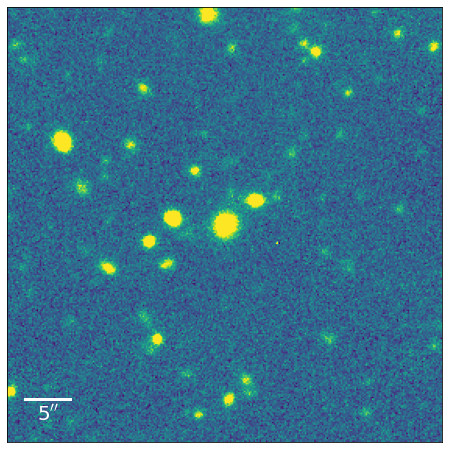

In [64]:
display_single(hdu[1].data);

In [44]:
cutout_cat['r_kronRad'].max()

21.19235

In [41]:
cutout_cat[(cutout_cat['z_cosmos'] > 0.02) & (cutout_cat['z_cosmos'] < 0.2)]

<Table length=1880>
     coord_ra          coord_dec             y_ra        ...        DEC         ID_yifei         RA        
     float64            float64            float64       ...      float64        int64        float64      
------------------ ------------------ ------------------ ... ------------------ -------- ------------------
  150.586732341986 1.6148100474860079   150.586733079837 ... 1.6147848030543372   220986 150.58673641329645
150.58469464086838 1.6260902366726813 150.58469225623816 ... 1.6261166465811245   229665 150.58469843588563
150.60158811778817 1.7436183612418568 150.60158705857614 ... 1.7436091278976715   300337 150.60159358980536
 150.5626866974805 1.6192233057880265 150.56268481693215 ... 1.6192274519789207   223203 150.56269167203442
150.64559712099614 1.7035957742692316 150.64559552358227 ... 1.7036315401596418   277061  150.6456064303682
150.66050963178668 1.7032875043840554   150.660501179531 ... 1.7033163879613582   276680 150.66051874785273
150.54156067940076 1.7091637173050565 150.54155231736073 ... 1.7091761574947526   281265 150.54153633059465
 150.5662231526054 1.7192708326508312  150.5662237083719 ... 1.7192644529566978   286219  150.5662299993118
 150.5529124753196  1.742418550086714 150.55290972442853 ...  1.742406017028826   299802   150.552889415208
 150.6122511388026 1.7443855296334805 150.61224851867146 ... 1.7443905688611807   303077 150.61225891043009
150.61081399570855 1.7491088692059875 150.61081341365085 ... 1.7491139623052554   304589 150.61082469154474
               ...                ...                ... ...                ...      ...                ...
149.96602017056202 2.7633763172700454  149.9660225633201 ... 2.7633336388598764   961434 149.96602802022332
149.79229720042576  2.766146281449647 149.79229820906582 ... 2.7661239499601873   963987 149.79230060805114
149.91938794550086  2.771128593504052 149.91938905310636 ...  2.771080061930811   966353 149.91939032320198
149.86485815621566 2.7956082337941277 149.86485918820262 ... 2.7955805917077825   981604 149.86486940612036
 149.8460488254952  2.796146529659327 149.84604784117468 ... 2.7961294800062335   986524 149.84605433915135
149.92380311338187 2.7966636731868677 149.92379802655006 ... 2.7966627703603546   983667 149.92379766539108
149.81706656577725   2.80710346481968  149.8170672511814 ... 2.8071099645215747   989491 149.81707352018657
149.69998220260868 2.7061211936479315 149.69997661629577 ... 2.7061508698624386   927632 149.69998006165238
 149.7351412272226  2.710130640974255 149.73514119225013 ... 2.7101265201590383   929194 149.73514369749418
149.77249603752537 2.7134588855120136 149.77249397426675 ... 2.7134550837155413   932426  149.7725006978424
 149.7460105159914 2.7141054292425086 149.74599662773423 ... 2.7141056991101182   931367  149.7460127708112
149.78237072250334  2.780652284134034 149.78237015631157 ... 2.7806504975079056   973431 149.78236767130684

In [7]:
iN708_gaap = (cutout_cat['i_gaap_mag'] - cutout_cat['N708_gaap_mag']).data
iN708_tractor = 2.5 * (np.log10(cutout_cat['N708_tractor_flux']) - np.log10(cutout_cat['i_tractor_flux']))

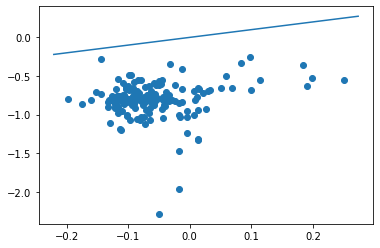

In [8]:
plt.scatter(iN708_gaap[:200], iN708_tractor[:200])
x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

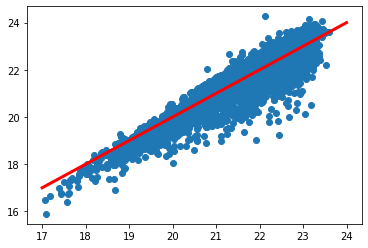

In [9]:
plt.scatter(cutout_cat['i_gaap_mag'], -2.5 * np.log10(cutout_cat['i_tractor_flux']) + 22.5)

x = np.linspace(17, 24)
plt.plot(x, x, lw=3, color='r')

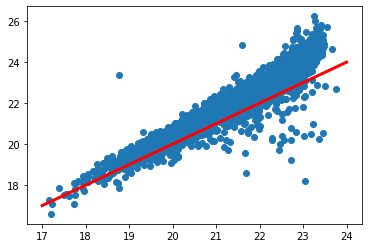

In [10]:
plt.scatter(cutout_cat['N708_gaap_mag'], -2.5 * np.log10(cutout_cat['N708_tractor_flux']) + 22.5)

x = np.linspace(17, 24)
plt.plot(x, x, lw=3, color='r')

---

In [19]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [20]:
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_lowz_calexp.fits')

In [21]:
len(obj_cat)

2001

### Also need to generate HSC cutouts

In [22]:
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts')
from s18a_batch_cutout import batch_cutout

In [23]:
DATADIR="/scratch/gpfs/jiaxuanl/Data/" # Directory of all data
LSBGDIR="/scratch/gpfs/jiaxuanl/Data/Merian/"

In [24]:
batch_cutout(DATADIR, 
             LSBGDIR + "Catalogs/COSMOS_cutouts_tractor_gaap_lowz_calexp.fits", 
             low=500, high=2001, size='half_size', unit='arcsec', 
             bands='grizy', name='ID', prefix='s18a_wide', njobs=3,
             overwrite=False)


 Number of jobs: 3

 Number of galaxies: 1501
    - Generate cutouts for 1501 galaxies in g-band.
    - Generate cutouts for 1501 galaxies in r-band.
    - Generate cutouts for 1501 galaxies in i-band.
    - Generate cutouts for 1501 galaxies in z-band.
    - Generate cutouts for 1501 galaxies in y-band.
Elapsed time: 7742.24 s


In [25]:
# N708
for obj in obj_cat[:]:
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_N708_deepCoadd_calexp.fits')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut_new', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/')
    os.system(f'cp {file} {newfile}')
    
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_N708_psf.fits')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut_new', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/')
    os.system(f'cp {file} {newfile}')

In [26]:
# N540
for obj in obj_cat[:]:
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_n540_deepCoadd_calexp.fits')
    file = file.replace('g09_broadcut_new', 'g09_broadcut')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/')
    newfile = newfile.replace('n540', 'N540')
    os.system(f'cp {file} {newfile}')
    
    file = os.path.join(obj['dir'], f'{obj["PREFIX"]}_n540_psf.fits')
    file = file.replace('g09_broadcut_new', 'g09_broadcut')
    newfile = file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                           '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/_new/')
    newfile = newfile.replace('n540', 'N540')
    os.system(f'cp {file} {newfile}')

In [49]:
obj

ID,PREFIX,dir,chunk,ra,dec,half_size,name,N708_tractor_flux,g_tractor_flux,r_tractor_flux,i_tractor_flux,z_tractor_flux,y_tractor_flux,tractor_sersic_index,tractor_re,g_gaap_mag,r_gaap_mag,i_gaap_mag,z_gaap_mag,y_gaap_mag,N708_gaap_mag,N540_gaap_mag,z_cosmos,mass_cosmos,ID_yifei
,,,,,,arcsec,,,,,,,,,,,,,,,,,,,
int64,bytes30,bytes65,int64,float64,float64,float64,bytes26,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
43158584464269160,g09_broadcut_43158584464269160,/projects/MERIAN/poststamps/g09_broadcut_new/21/43158584464269160,21,150.24015958954186,1.6278470294283613,8.966204135530264,cosmos_43158584464269160_y,0.31933787339460457,0.27624915307852543,0.5774337596535115,0.7590125450373362,0.9010435911305796,1.0549070561963656,0.0,0.46970513203725595,23.851113120039912,23.035300837876484,22.781219061594122,22.529853898129744,22.52245767517013,22.88666185808163,23.353810700829325,0.3319000005722046,9.04985,230148
